# Convolution Neural Network Model.

**In this notebook we will look at the steps taken to build a cNN for the predicts of weather in any given image.**

The first thing we need is the libraries, so let's import what we need.

In [1]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2

Using TensorFlow backend.


Next we need to set some common varables that can be used though out the model.

In [2]:
# dimensions of our images.
img_width, img_height = 224, 224

In [3]:
# get the pre-train bottle neck model
top_model_weights_path = 'bottleneck_fc_model.h5'

In [4]:
# My training and validation sets
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'

In [5]:
# number of epochs to train top model
epochs = 50

In [6]:
# batch size used by flow_from_directory and predict_generator
batch_size = 16

Now we have the bases cover, let us start by creating a function for the VGG16 bottleneck. 

We want to import the pre-train dataset, that ImageNet has built for us. From that we can use that set to complelent what we have ourselfs.

In [7]:
def save_bottlebeck_features():
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    datagen = ImageDataGenerator(rescale=1. / 255)

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    print(len(generator.filenames))
    print(generator.class_indices)
    print(len(generator.class_indices))

    nb_train_samples = len(generator.filenames)
    num_classes = len(generator.class_indices)

    predict_size_train = int(math.ceil(nb_train_samples / batch_size))

    bottleneck_features_train = model.predict_generator(
        generator, predict_size_train)

    np.save('bottleneck_features_train.npy', bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_validation_samples = len(generator.filenames)

    predict_size_validation = int(
        math.ceil(nb_validation_samples / batch_size))

    bottleneck_features_validation = model.predict_generator(
        generator, predict_size_validation)

    np.save('bottleneck_features_validation.npy',
            bottleneck_features_validation)

Next we want to train our sets, we do this by connecting to the already train bottle neck. From that we just have to use the fully-connected function of keras. This part is what makes our model unique to any order model. 

In [8]:
def train_top_model():
    datagen_top = ImageDataGenerator(rescale=1. / 255)
    generator_top = datagen_top.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

    nb_train_samples = len(generator_top.filenames)
    num_classes = len(generator_top.class_indices)

    # save the class indices to use use later in predictions
    np.save('class_indices.npy', generator_top.class_indices)

    # load the bottleneck features saved earlier
    train_data = np.load('bottleneck_features_train.npy')

    # get the class lebels for the training data, in the original order
    train_labels = generator_top.classes

    # https://github.com/fchollet/keras/issues/3467
    # convert the training labels to categorical vectors
    train_labels = to_categorical(train_labels, num_classes=num_classes)

    generator_top = datagen_top.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    nb_validation_samples = len(generator_top.filenames)

    validation_data = np.load('bottleneck_features_validation.npy')

    validation_labels = generator_top.classes
    validation_labels = to_categorical(
        validation_labels, num_classes=num_classes)

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_data, train_labels,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(validation_data, validation_labels))

    model.save_weights(top_model_weights_path)

    (eval_loss, eval_accuracy) = model.evaluate(
        validation_data, validation_labels, batch_size=batch_size, verbose=1)

    print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
    print("[INFO] Loss: {}".format(eval_loss))

    plt.figure(1)

    # summarize history for accuracy

    plt.subplot(211)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss

    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

The last part of this process is the predict part. Here we want to take a image and see what the system thinks is the outcome.

For this we need to run though some of the process we already done before, from that we can output a result.

In [9]:
def predict():
    # load the class_indices saved in the earlier step
    class_dictionary = np.load('class_indices.npy').item()

    num_classes = len(class_dictionary)

    # add the path to your test image below
    image_path = 'C:\\Users\\robert\\Documents\\Bob College work\\Year 4\\Project\\Images\\the-spike6.jpg'

    orig = cv2.imread(image_path)

    print("[INFO] loading and preprocessing image...")
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)

    # important! otherwise the predictions will be '0'
    image = image / 255

    image = np.expand_dims(image, axis=0)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    # get the bottleneck prediction from the pre-trained VGG16 model
    bottleneck_prediction = model.predict(image)

    # build top model
    model = Sequential()
    model.add(Flatten(input_shape=bottleneck_prediction.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))

    model.load_weights(top_model_weights_path)

    # use the bottleneck prediction on the top model to get the final
    # classification
    class_predicted = model.predict_classes(bottleneck_prediction)

    probabilities = model.predict_proba(bottleneck_prediction)

    inID = class_predicted[0]

    inv_map = {v: k for k, v in class_dictionary.items()}

    label = inv_map[inID]

    # get the prediction label
    print("Image ID: {}, Label: {}".format(inID, label))

    # display the predictions with the image
    cv2.putText(orig, "Predicted: {}".format(label), (10, 30),
                cv2.FONT_HERSHEY_PLAIN, 1.5, (43, 99, 255), 2)

    cv2.imshow("Classification", orig)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Now we run the above function and see what happens.

Found 500 images belonging to 5 classes.
500
{'Light Cloud': 0, 'Overcast': 1, 'Stormy': 2, 'Sunny': 3, 'Very Cloudy': 4}
5
Found 100 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Found 100 images belonging to 5 classes.
Train on 500 samples, validate on 100 samples
Epoch 1/50
500/500 [==============================] - 4s - loss: 3.4293 - acc: 0.2160 - val_loss: 1.6094 - val_acc: 0.2300
Epoch 2/50
500/500 [==============================] - 4s - loss: 1.6797 - acc: 0.2040 - val_loss: 1.6094 - val_acc: 0.2000
Epoch 3/50
500/500 [==============================] - 4s - loss: 1.6093 - acc: 0.2040 - val_loss: 1.6996 - val_acc: 0.2000
Epoch 4/50
500/500 [==============================] - 4s - loss: 1.7525 - acc: 0.2080 - val_loss: 1.6097 - val_acc: 0.2000
Epoch 5/50
500/500 [==============================] - 4s - loss: 1.6554 - acc: 0.2000 - val_loss: 1.6094 - val_acc: 0.2000
Epoch 6/50
500/500 [==============================] - 4s - loss: 1.6740 - acc: 0.1940 - val_

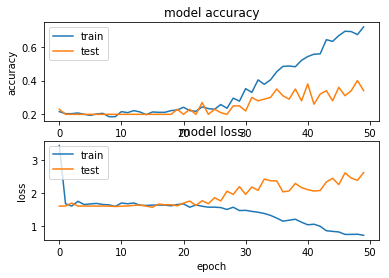

[INFO] loading and preprocessing image...
1/1 [==============================] - 0s
Image ID: 0, Label: Light Cloud


In [10]:
save_bottlebeck_features()
train_top_model()
predict()

cv2.destroyAllWindows()